In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Common imports
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# Etude 1 - Image Classifier Based on the Denoising Autoencoder

Try using a denoising autoencoder to pretrain an image classifier. You can use MNIST (the simplest option), or a more complex image dataset such as CIFAR10
if you want a bigger challenge. Regardless of the dataset you’re using, follow these steps:
- Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.
- Check that the images are fairly well reconstructed. Visualize the images that most activate each neuron in the coding layer.
- Build a classification DNN, reusing the lower layers of the autoencoder. Train it using only 500 images from the training set. Does it perform better with or without pretraining?

In [ ]:
cifar10, cifar_info = tfds.load("cifar10:3.*.*", with_info=True)

In [ ]:
cifar_info

tfds.core.DatasetInfo(
    name='cifar10',
    version=3.0.0,
    description='The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multiple layers of features from tiny images},
        institution = {},
        year = {2009}
    }""",
    redistribution_info=,
)

In [ ]:
BATCH_SIZE = 64
NUM_CLASSES = 10

In [ ]:
cifar10_test = tfds.load("cifar10:3.*.*", as_supervised=True, split='test') 
cifar10_train = tfds.load("cifar10:3.*.*", as_supervised=True, split='train[:40000]') 
cifar10_valid = tfds.load("cifar10:3.*.*", as_supervised=True, split='train[40000:]') # 10000 samples

In [ ]:
def calculate_dataset_size(dataset):
    """Returns the dataset length."""
    item_count = 0
    for item in dataset:
        item_count += 1
    return item_count

In [ ]:
test_size = calculate_dataset_size(cifar10_test)
train_size = calculate_dataset_size(cifar10_train)
validation_size = calculate_dataset_size(cifar10_valid)

In [ ]:
cifar10_train = cifar10_train.cache().map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
cifar10_test = cifar10_test.cache().map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
cifar10_valid = cifar10_valid.cache().map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))

In [ ]:
# full dataset for training the reference classifier
cifar10_train_classifier = cifar10_train.shuffle(1000).repeat().batch(BATCH_SIZE)
cifar10_test_classifier = cifar10_test.batch(BATCH_SIZE)
cifar10_valid_classifier = cifar10_valid.batch(BATCH_SIZE)

In [ ]:
# full dataset for traning the AE where label is replaces with the input
cifar10_train_ae = cifar10_train.map(lambda x, y: (x, x)).shuffle(1000).repeat().batch(BATCH_SIZE)
cifar10_test_ae = cifar10_test.map(lambda x, y: (x, x)).batch(BATCH_SIZE)
cifar10_valid_ae = cifar10_valid.map(lambda x, y: (x, x)).batch(BATCH_SIZE)

First let's create a rather simple reference CIFAR10 classifier. This classifier is based on the VGG architecture.

In [ ]:
reference_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu', input_shape = (32, 32, 3)),
    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same", activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),    
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
reference_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

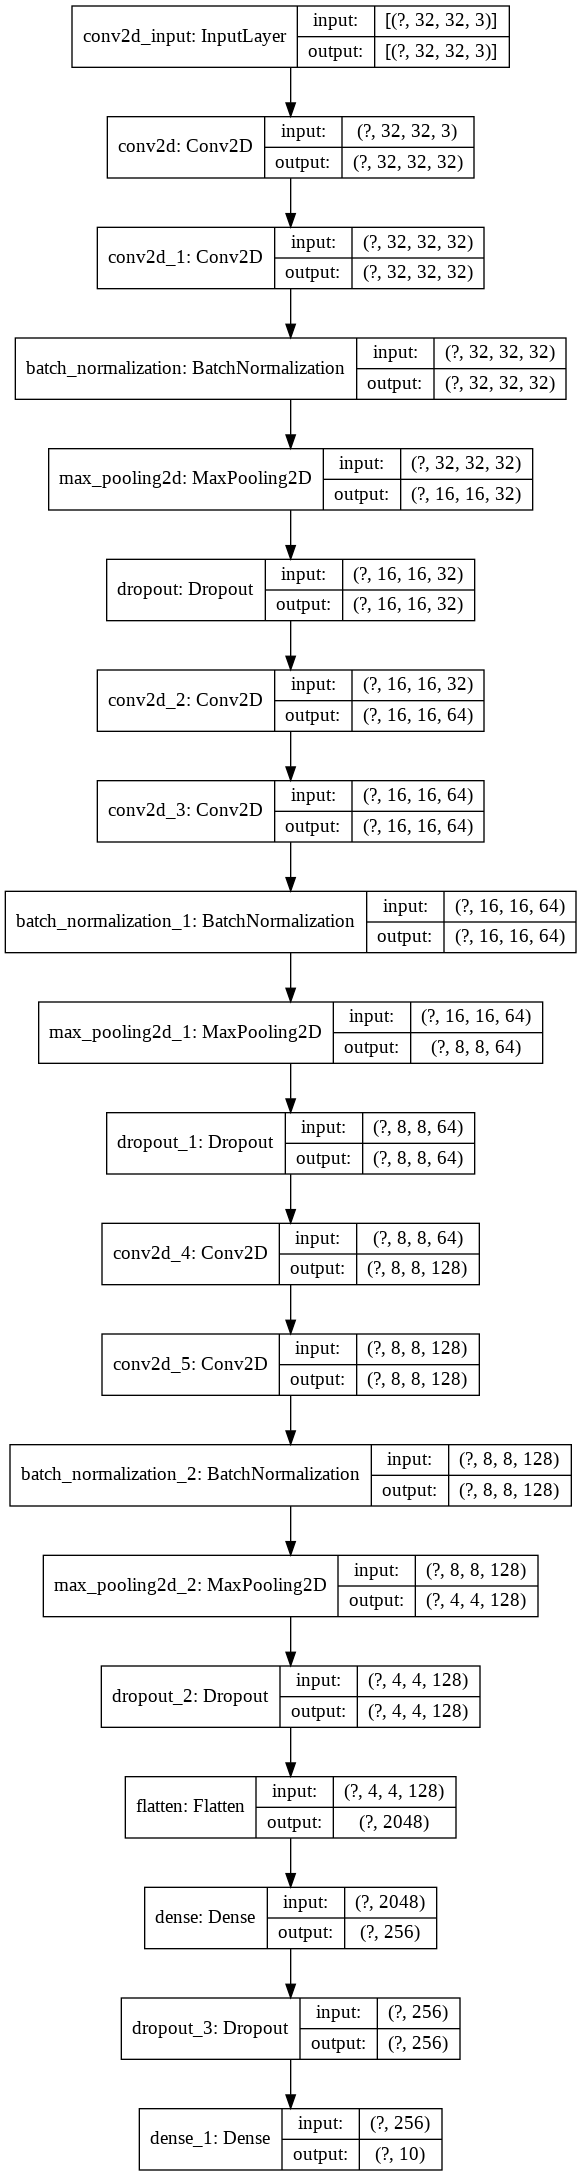

In [ ]:
keras.utils.plot_model(reference_model, show_shapes=True)

In [ ]:
# classifier training and evaluation
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00004)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)

reference_model.fit(cifar10_train_classifier, epochs=40, callbacks=[early_stopping_cb, reduce_lr], 
                    validation_data=cifar10_valid_classifier,
                    steps_per_epoch=int(train_size / BATCH_SIZE),
                    validation_steps=int(validation_size / BATCH_SIZE))

Epoch 1/40
625/625 [==============================] - 23s 36ms/step - loss: 1.7057 - accuracy: 0.3893 - val_loss: 1.5978 - val_accuracy: 0.4051
Epoch 2/40
625/625 [==============================] - 15s 24ms/step - loss: 1.2901 - accuracy: 0.5385 - val_loss: 1.1827 - val_accuracy: 0.5857
Epoch 3/40
625/625 [==============================] - 15s 24ms/step - loss: 1.0844 - accuracy: 0.6170 - val_loss: 0.9746 - val_accuracy: 0.6603
Epoch 4/40
625/625 [==============================] - 14s 22ms/step - loss: 0.9486 - accuracy: 0.6682 - val_loss: 0.9126 - val_accuracy: 0.6751
Epoch 5/40
625/625 [==============================] - 14s 22ms/step - loss: 0.8554 - accuracy: 0.7016 - val_loss: 0.9006 - val_accuracy: 0.6788
Epoch 6/40
625/625 [==============================] - 15s 24ms/step - loss: 0.7892 - accuracy: 0.7237 - val_loss: 0.7452 - val_accuracy: 0.7422
Epoch 7/40
625/625 [==============================] - 14s 22ms/step - loss: 0.7294 - accuracy: 0.7469 - val_loss: 0.8998 - val_accuracy:

In [ ]:
reference_model.evaluate(cifar10_test_classifier, steps=int(test_size / BATCH_SIZE))

156/156 [==============================] - 3s 20ms/step - loss: 0.6133 - accuracy: 0.8447


[0.6132787466049194, 0.844651460647583]

We achieved about 85% accuracy on the entire dataset using this model (this model is prone to overfitting). Now let's create a convolutional denoising autoencoder. For the encoder part, let's use the simplified version of the VGG architecture.

In [ ]:
cif_enc = keras.models.Sequential([
    keras.layers.GaussianNoise(0.15, input_shape = [32, 32, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=2, strides=2, padding="same", activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, padding="same", activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters=64, kernel_size=2, strides=2, padding="same", activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=2, strides=1, padding="same", activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters=128, kernel_size=2, strides=2, padding="same", activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=2, strides=1, padding="same", activation='relu')    
])

cif_dec = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding="same", activation="relu", input_shape=[4, 4, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=2, strides=1, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2DTranspose(32, kernel_size=2, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(32, kernel_size=2, strides=1, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2DTranspose(3, kernel_size=2, strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(3, kernel_size=2, strides=1, padding="same", activation="sigmoid")    
])

cif_conv_ae = keras.models.Sequential([cif_enc, cif_dec])
cif_conv_ae.compile(loss="binary_crossentropy", optimizer="nadam")

As a sanity check, let's plot the encoder and decoder model to make sure that the dimensions are correct.

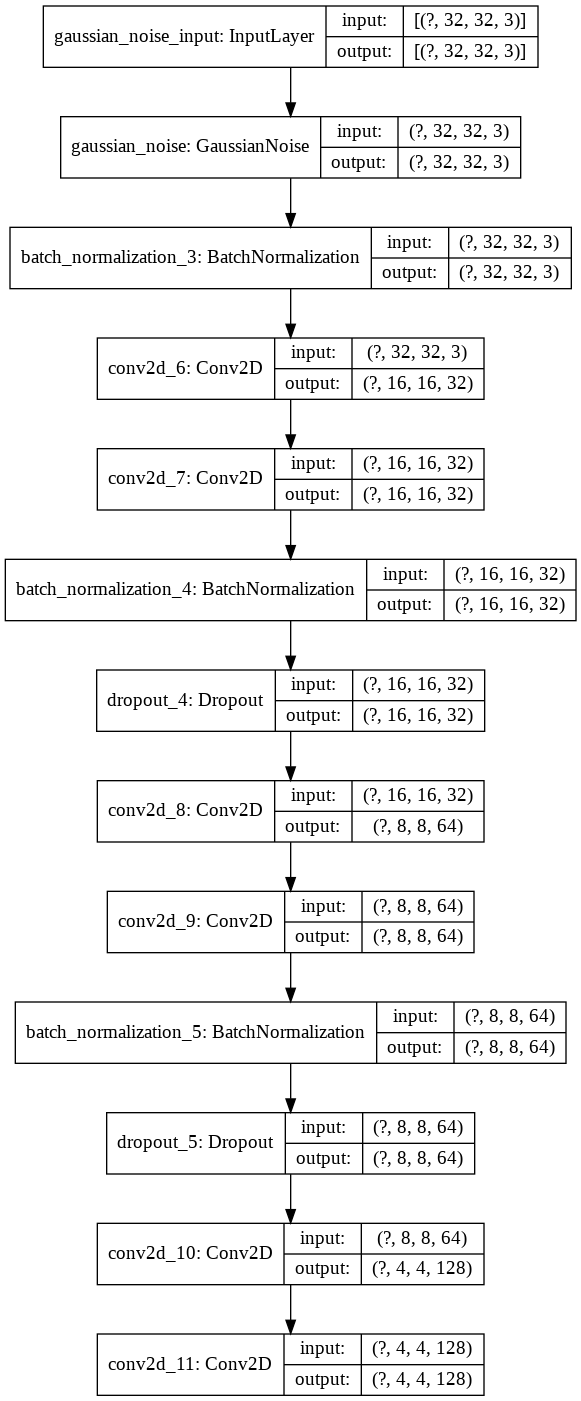

In [ ]:
keras.utils.plot_model(cif_enc, show_shapes=True)

The latent space is represented by 2048 neurons. Let's plot the decoder model.

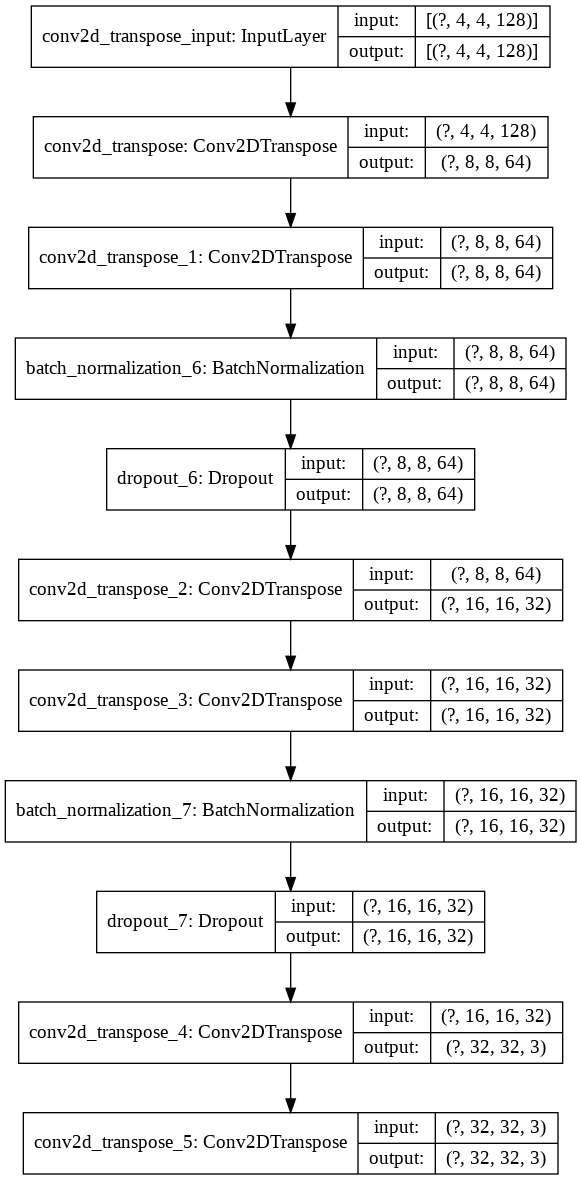

In [ ]:
keras.utils.plot_model(cif_dec, show_shapes=True)

Let's write the function that allows us to visually compare the original and reconstructed images to make sure that the images are reconstructed well.

In [ ]:
def display_ori_vs_reconstructed_images(model, dataset):
    """Displays three images and their reconstructions."""
    plt.figure(figsize=(6, 7))
    index = 1
    
    for image in dataset.shuffle(100).take(3):
        plt.subplot(3, 2, index)
        plt.axis("off")
        if index < 3:
            plt.title('Original')
        plt.imshow(image[0])
        index += 1
        plt.subplot(3, 2, index)
        #  we need the fourth, batch dimension for the model to predict 
        predicted_image = model.predict(tf.expand_dims(image[0], 0))
        plt.axis("off")
        if index < 3:
            plt.title('Reconstructed')
        plt.imshow(tf.reshape(predicted_image, [32, 32, 3])) # reshaping the predicted image back
        index += 1

In [ ]:
cif_conv_ae.fit(cifar10_train_ae, epochs=35, callbacks=[early_stopping_cb, reduce_lr],
                validation_data=cifar10_valid_ae, steps_per_epoch=int(train_size / BATCH_SIZE), 
                validation_steps=int(validation_size / BATCH_SIZE))

Epoch 1/35
625/625 [==============================] - 16s 26ms/step - loss: 0.5881 - val_loss: 0.5786
Epoch 2/35
625/625 [==============================] - 15s 23ms/step - loss: 0.5755 - val_loss: 0.5696
Epoch 3/35
625/625 [==============================] - 14s 23ms/step - loss: 0.5740 - val_loss: 0.5686
Epoch 4/35
625/625 [==============================] - 14s 22ms/step - loss: 0.5710 - val_loss: 0.5616
Epoch 5/35
625/625 [==============================] - 14s 22ms/step - loss: 0.5666 - val_loss: 0.5594
Epoch 6/35
625/625 [==============================] - 14s 23ms/step - loss: 0.5649 - val_loss: 0.5582
Epoch 7/35
625/625 [==============================] - 14s 22ms/step - loss: 0.5641 - val_loss: 0.5579
Epoch 8/35
625/625 [==============================] - 14s 22ms/step - loss: 0.5635 - val_loss: 0.5582
Epoch 9/35
625/625 [==============================] - 14s 22ms/step - loss: 0.5631 - val_loss: 0.5579
Epoch 10/35
625/625 [==============================] - 14s 23ms/step - loss: 0.562

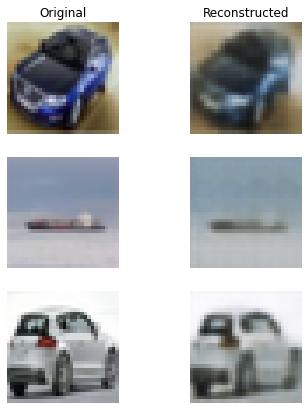

In [ ]:
display_ori_vs_reconstructed_images(cif_conv_ae, cifar10_test)

Now let's write a function that visualizes 20 images that most activate random coding neurons in the encoder.

In [ ]:
def get_images_for_most_activated_neurons(encoder, dataset):
    """Displays images that most activate 20 randomly selected coding neurons in the encoder.
    The dataset should not contain the batch dimension."""
    
    plt.figure(figsize=(7, 5))
        
    # we remove the label so that when converting the dataset
    # to a numpy array using as_numpy() so that we do not need 
    # to remove the label from the array as it is not a simple task 
    # (because a label is represented as an additional tuple which cannot be
    # accessed by an index for some reason)
    dataset_np = dataset.map(lambda x, y: (x))

    # converting the dataset to a numpy array (iterator) 
    dataset_np_iter = tfds.as_numpy(dataset_np)
    
    X_codings = encoder.predict(dataset_np.batch(1))
    
    # flattening codings to shape [n_samples, n_codings]
    X_codings_flattened = tf.reshape(X_codings, [X_codings.shape[0], -1])
    
    # here we find the indexes of the images that most activate each neuron
    max_arg = tf.math.argmax(X_codings_flattened, 0)
    
    # here we remove duplicates, since different neurons can be activated by the same image
    # if we do not do this, there may be situations when the same index will multiple times;
    # as a result, sampling may return the same image several times,
    # leading to a situation when not 20, but, for example, 17 images will be displayed
    max_arg, idx = tf.unique(max_arg)
   
    indices = sorted(np.random.choice(max_arg, 20, replace=False))
      
    # iterate over the numpy version of the dataset and visualize images
    # with randomly seleceted indices
    index = 0
    image_index = 1
    for image in dataset_np_iter:
        if index in indices:
            plt.subplot(4, 5, image_index)
            plt.axis("off")
            plt.imshow(image)
            image_index += 1
        index += 1    

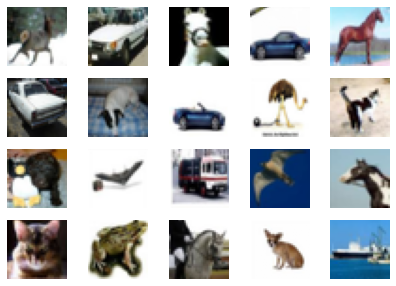

In [ ]:
get_images_for_most_activated_neurons(cif_enc, cifar10_test)

Now let's build a classification DNN using the pretrained encoder. We will train the network using 10000 images only - 1000 for each of class.

In [ ]:
flattening_layer = keras.layers.Flatten()
dense_layer = keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
conv_layer = keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="same", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))
classification_layer = keras.layers.Dense(NUM_CLASSES, activation='softmax')

In [ ]:
# AE-based classifier
classifier = tf.keras.Sequential([
  cif_enc,
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.5),
  conv_layer,
  keras.layers.BatchNormalization(),
  keras.layers.Dropout(0.5),
  dense_layer,
  flattening_layer,  
  classification_layer
])

Let's first freeze the encoder layers.

In [ ]:
cif_enc.trainable = False

In [ ]:
classifier.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

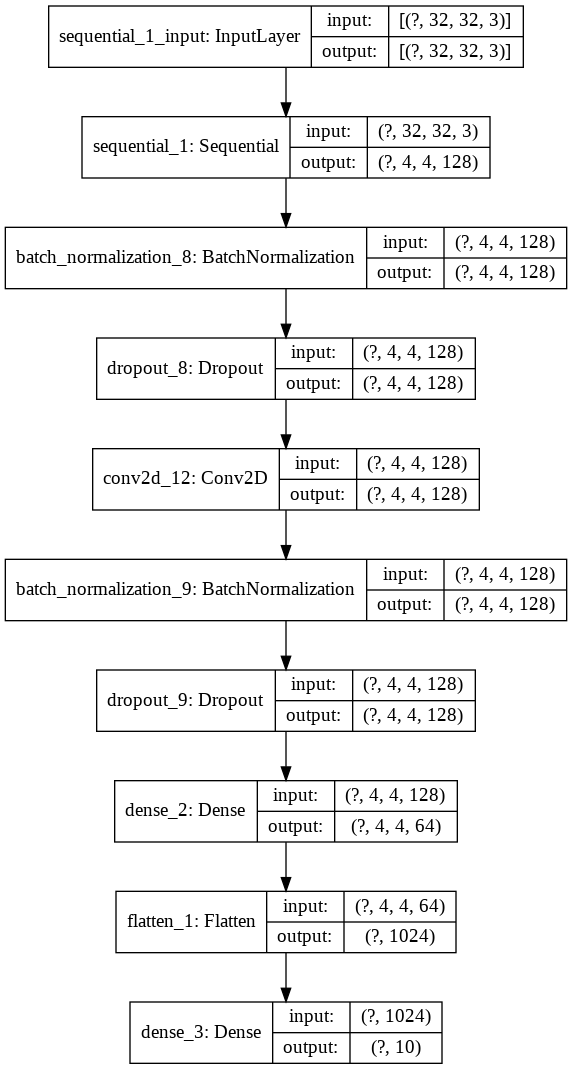

In [ ]:
keras.utils.plot_model(classifier, show_shapes=True)

Now let's prepare the reduced dataset that has 1000 instances per class.

In [ ]:
def create_reduced_dataset(dataset, num_classes=10, num_samples=1000):
    """Creates a dataset where each class is represented by the specified
    number of samples."""
    # remember that the expression in filter() should return a boolean value
    dataset_reduced = dataset.filter(lambda x, y: tf.math.equal(y, 0)).take(num_samples)
    
    for i in range(1, num_classes):
        dataset_red = dataset.filter(lambda x, y: tf.math.equal(y, i)).take(num_samples)
        dataset_reduced = dataset_reduced.concatenate(dataset_red)
    
    return dataset_reduced

In [ ]:
cifar10_train_reduced = create_reduced_dataset(cifar10_train)
train_size_reduced = calculate_dataset_size(cifar10_train_reduced)

Now let's prepare the reduced dataset for the AE-based classifier.

In [ ]:
# reduced dataset to train the AE-based classifier
# we shuffle the entire dateset and use cache() afterwards to prevent the dataset
# from being shuffled at each epoch

cifar10_train_reduced = cifar10_train_reduced.shuffle(10000).cache().repeat().batch(BATCH_SIZE) 

In [ ]:
classifier.fit(cifar10_train_reduced, epochs=25, validation_data=cifar10_valid_classifier, callbacks=[early_stopping_cb, reduce_lr],
               steps_per_epoch=int(train_size_reduced / BATCH_SIZE), validation_steps=int(validation_size / BATCH_SIZE))

Epoch 1/25
156/156 [==============================] - 3s 18ms/step - loss: 2.4373 - accuracy: 0.2589 - val_loss: 1.9260 - val_accuracy: 0.3930
Epoch 2/25
156/156 [==============================] - 3s 16ms/step - loss: 2.0789 - accuracy: 0.3417 - val_loss: 1.8511 - val_accuracy: 0.4027
Epoch 3/25
156/156 [==============================] - 3s 16ms/step - loss: 1.9509 - accuracy: 0.3710 - val_loss: 1.8073 - val_accuracy: 0.4235
Epoch 4/25
156/156 [==============================] - 3s 16ms/step - loss: 1.8682 - accuracy: 0.4050 - val_loss: 1.7727 - val_accuracy: 0.4356
Epoch 5/25
156/156 [==============================] - 3s 16ms/step - loss: 1.8184 - accuracy: 0.4189 - val_loss: 1.7282 - val_accuracy: 0.4475
Epoch 6/25
156/156 [==============================] - 2s 16ms/step - loss: 1.7758 - accuracy: 0.4301 - val_loss: 1.7182 - val_accuracy: 0.4512
Epoch 7/25
156/156 [==============================] - 3s 16ms/step - loss: 1.7488 - accuracy: 0.4386 - val_loss: 1.6957 - val_accuracy: 0.4570

Let's unfreeze the encoder layers.

In [ ]:
cif_enc.trainable = True

In [ ]:
classifier.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
classifier.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 4, 4, 128)         128204    
_________________________________________________________________
batch_normalization_8 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
dropout_8 (Dropout)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
batch_normalization_9 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
dropout_9 (Dropout)          (None, 4, 4, 128)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 4, 4, 64)         

In [ ]:
classifier.fit(cifar10_train_reduced, epochs=40, validation_data=cifar10_valid_classifier, callbacks=[early_stopping_cb, reduce_lr],
               steps_per_epoch=int(train_size_reduced / BATCH_SIZE), validation_steps=int(validation_size / BATCH_SIZE))

Epoch 1/40
156/156 [==============================] - 3s 20ms/step - loss: 1.5287 - accuracy: 0.5181 - val_loss: 1.6445 - val_accuracy: 0.4851
Epoch 2/40
156/156 [==============================] - 3s 18ms/step - loss: 1.4794 - accuracy: 0.5380 - val_loss: 1.5805 - val_accuracy: 0.5053
Epoch 3/40
156/156 [==============================] - 3s 17ms/step - loss: 1.4578 - accuracy: 0.5416 - val_loss: 1.5595 - val_accuracy: 0.5126
Epoch 4/40
156/156 [==============================] - 3s 17ms/step - loss: 1.4265 - accuracy: 0.5558 - val_loss: 1.5557 - val_accuracy: 0.5155
Epoch 5/40
156/156 [==============================] - 3s 18ms/step - loss: 1.4059 - accuracy: 0.5612 - val_loss: 1.5807 - val_accuracy: 0.5057
Epoch 6/40
156/156 [==============================] - 3s 18ms/step - loss: 1.3842 - accuracy: 0.5723 - val_loss: 1.5937 - val_accuracy: 0.5082
Epoch 7/40
156/156 [==============================] - 3s 17ms/step - loss: 1.3722 - accuracy: 0.5758 - val_loss: 1.6161 - val_accuracy: 0.5025

In [ ]:
classifier.evaluate(cifar10_test_classifier, steps=int(test_size / BATCH_SIZE))

156/156 [==============================] - 1s 6ms/step - loss: 1.4384 - accuracy: 0.5691


[1.4384390115737915, 0.5691105723381042]

The achieved accuracy at least 20% lower (depending on the run) than when using the reference CNN classifier on the entire dataset. Using a more simpler version of the encoder led to lower accuracy even though some authors claim that using the shallower autoencoders should help.

Let's try to retrain the same AE-based classifier without pretraining the encoder layers. To do this, let's clone the model to reset the weights.

In [ ]:
classifier_reset = tf.keras.models.clone_model(classifier)

classifier_reset.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
classifier_reset.fit(cifar10_train_reduced, epochs=45, validation_data=cifar10_valid_classifier, callbacks=[early_stopping_cb, reduce_lr],
               steps_per_epoch=int(train_size_reduced / BATCH_SIZE), validation_steps=int(validation_size / BATCH_SIZE))

Epoch 1/45
156/156 [==============================] - 3s 19ms/step - loss: 2.6875 - accuracy: 0.1890 - val_loss: 2.8187 - val_accuracy: 0.0985
Epoch 2/45
156/156 [==============================] - 3s 18ms/step - loss: 2.1952 - accuracy: 0.2912 - val_loss: 2.7444 - val_accuracy: 0.1900
Epoch 3/45
156/156 [==============================] - 3s 18ms/step - loss: 2.0323 - accuracy: 0.3408 - val_loss: 2.0126 - val_accuracy: 0.3589
Epoch 4/45
156/156 [==============================] - 3s 17ms/step - loss: 1.9188 - accuracy: 0.3757 - val_loss: 1.8888 - val_accuracy: 0.3997
Epoch 5/45
156/156 [==============================] - 3s 18ms/step - loss: 1.8378 - accuracy: 0.4018 - val_loss: 1.7454 - val_accuracy: 0.4387
Epoch 6/45
156/156 [==============================] - 3s 18ms/step - loss: 1.7754 - accuracy: 0.4181 - val_loss: 1.6755 - val_accuracy: 0.4575
Epoch 7/45
156/156 [==============================] - 3s 18ms/step - loss: 1.7125 - accuracy: 0.4457 - val_loss: 1.6416 - val_accuracy: 0.4721

In [ ]:
classifier_reset.evaluate(cifar10_test_classifier, steps=int(test_size / BATCH_SIZE))

156/156 [==============================] - 1s 6ms/step - loss: 1.4679 - accuracy: 0.5508


[1.467905044555664, 0.55078125]

We see that the pretrained AE-based classifier on average showed aprox. the same results as the AE-based classifier without pretraining.

For experimental purposes, let's create a model that combines the autoencoder and classifier, and then let's try to train it on the full and then reduced datasets to compare it with the reference model and with the pretrained autoencoder model. The autoencoder used in this model is a bit simpler than the one that was used in the initial AE.

In [ ]:
def create_block(input, filters):
    """Model block of 2 CNN layers"""
    x = input
    for i in range(2):
        x = keras.layers.Conv2D(filters, 3, padding="same", activation='relu')(x)
        x = keras.layers.BatchNormalization()(x)
    return x

In [ ]:
inputs = keras.layers.Input(shape=(32, 32, 3))

# Encoder
block1 = create_block(inputs, 32)
x = keras.layers.MaxPool2D(2)(block1)
block2 = create_block(x, 64)
x = keras.layers.MaxPool2D(2)(block2)

# Middle Part
middle = create_block(x, 128)

# Decoder
x = keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2)(middle)
x = keras.layers.Concatenate()([block2, x])
x = create_block(x, 64)
x = keras.layers.Conv2DTranspose(32, kernel_size=2, strides=2)(x)
x = keras.layers.Concatenate()([block1, x])
x = create_block(x, 32)

# Reconstruction
reconstruction = keras.layers.Conv2D(filters=3, kernel_size=1, padding="same", activation='sigmoid', name='autoencoder')(x)

# Classification
c = keras.layers.Conv2D(1024, 3, padding="same", activation='relu')(middle)
c = keras.layers.BatchNormalization()(c)
c = keras.layers.MaxPool2D(2)(c)
c = keras.layers.Dropout(0.5)(c)
c = keras.layers.Conv2D(128, 3, padding="same", activation='relu')(c)
c = keras.layers.BatchNormalization()(c)
c = keras.layers.MaxPool2D(2)(c)
c = keras.layers.Dropout(0.4)(c)
c = keras.layers.Flatten()(c)
c = keras.layers.Dense(512, activation='relu')(c)
c = keras.layers.Dropout(0.35)(c)
c = keras.layers.Dense(100, activation='relu')(c)
c = keras.layers.Dropout(0.69)(c)
classify = keras.layers.Dense(10, activation='softmax', name='classification')(c)
    
outputs = [reconstruction, classify]

In [ ]:
model_combined = keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_combined.compile(loss = {'classification': 'sparse_categorical_crossentropy', 'autoencoder': 'binary_crossentropy'}, 
                  optimizer = tf.keras.optimizers.SGD(lr= 0.01, momentum= 0.9),
                  metrics = {'classification': ['accuracy'], 'autoencoder': []})

In [ ]:
def create_reduced_dataset_multi(dataset, num_classes=10, num_samples=800):
    """Creates a dataset where each class is represented by the specified
    number of samples."""
    # remember that the expression in filter() should return a boolean value
    dataset_reduced = dataset.filter(lambda x, y: tf.math.equal(y[1], 0)).take(num_samples)
    
    for i in range(1, num_classes):
        dataset_red = dataset.filter(lambda x, y: tf.math.equal(y[1], i)).take(num_samples)
        # dataset_reduced = dataset_reduced.concatenate(dataset_red).shuffle(tf.cast(((num_classes * num_samples) / 2), tf.int64))
        dataset_reduced = dataset_reduced.concatenate(dataset_red)
    
    return dataset_reduced

Let's prepare the dataset. We need to change the label so that it includes X for the autoencoder and a class for the classifier.

In [ ]:
# train multimodel
cifar10_train_multi = cifar10_train.map(lambda x, y: (x, (x, y)))
cifar10_valid_multi = cifar10_valid.map(lambda x, y: (x, (x, y)))
cifar10_test_multi = cifar10_test.map(lambda x, y: (x, (x, y)))

In [ ]:
cifar10_train_reduced_multi = create_reduced_dataset_multi(cifar10_train_multi)
cifar10_train_reduced_multi = cifar10_train_reduced_multi.shuffle(10000, reshuffle_each_iteration=False).cache().repeat().batch(BATCH_SIZE)

In [ ]:
cifar10_test_multi = cifar10_test_multi.batch(BATCH_SIZE)
cifar10_valid_multi = cifar10_valid_multi.batch(BATCH_SIZE)

Let's train this multimodel classifier on the reduced dataset.

In [ ]:
model_combined.fit(cifar10_train_reduced_multi, epochs=50, callbacks=[early_stopping_cb, reduce_lr], 
                    validation_data=cifar10_valid_multi,
                    steps_per_epoch=int(train_size_reduced / BATCH_SIZE),
                    validation_steps=int(validation_size / BATCH_SIZE))

Epoch 1/50
156/156 [==============================] - 13s 83ms/step - loss: 2.9703 - autoencoder_loss: 0.5949 - classification_loss: 2.3754 - classification_accuracy: 0.1328 - val_loss: 2.8112 - val_autoencoder_loss: 0.5957 - val_classification_loss: 2.2155 - val_classification_accuracy: 0.1765
Epoch 2/50
156/156 [==============================] - 13s 81ms/step - loss: 2.7278 - autoencoder_loss: 0.5651 - classification_loss: 2.1626 - classification_accuracy: 0.1798 - val_loss: 2.5645 - val_autoencoder_loss: 0.5748 - val_classification_loss: 1.9897 - val_classification_accuracy: 0.2139
Epoch 3/50
156/156 [==============================] - 13s 81ms/step - loss: 2.6285 - autoencoder_loss: 0.5642 - classification_loss: 2.0642 - classification_accuracy: 0.2098 - val_loss: 2.4588 - val_autoencoder_loss: 0.5660 - val_classification_loss: 1.8928 - val_classification_accuracy: 0.2461
Epoch 4/50
156/156 [==============================] - 13s 80ms/step - loss: 2.5478 - autoencoder_loss: 0.5624 - 

In [ ]:
model_combined.evaluate(cifar10_test_multi, steps=int(test_size / BATCH_SIZE))

156/156 [==============================] - 3s 19ms/step - loss: 1.8482 - autoencoder_loss: 0.5572 - classification_loss: 1.2910 - classification_accuracy: 0.6215


[1.8481945991516113,
 0.5572293400764465,
 1.2909647226333618,
 0.6214944124221802]

Even with a simpler autoencoder, we could achieve a slightly better result than with the pretrained AE-based classifier (even though this model is prone to overfitting). For comparison, let's retrain the reference CNN classifier using the reduced dataset and compare the results.

In [ ]:
# to reset weights
reference_model = tf.keras.models.clone_model(reference_model)
reference_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
reference_model.fit(cifar10_train_reduced, epochs=40, callbacks=[early_stopping_cb, reduce_lr], 
                    validation_data=cifar10_valid_classifier,
                    steps_per_epoch=int(train_size_reduced / BATCH_SIZE),
                    validation_steps=int(validation_size / BATCH_SIZE))

Epoch 1/40
156/156 [==============================] - 4s 26ms/step - loss: 2.0960 - accuracy: 0.2764 - val_loss: 4.5147 - val_accuracy: 0.1561
Epoch 2/40
156/156 [==============================] - 4s 25ms/step - loss: 1.6937 - accuracy: 0.3808 - val_loss: 3.5476 - val_accuracy: 0.1735
Epoch 3/40
156/156 [==============================] - 4s 25ms/step - loss: 1.5724 - accuracy: 0.4304 - val_loss: 2.6962 - val_accuracy: 0.2721
Epoch 4/40
156/156 [==============================] - 4s 25ms/step - loss: 1.4562 - accuracy: 0.4669 - val_loss: 1.7156 - val_accuracy: 0.4339
Epoch 5/40
156/156 [==============================] - 4s 25ms/step - loss: 1.3670 - accuracy: 0.4994 - val_loss: 1.5605 - val_accuracy: 0.4869
Epoch 6/40
156/156 [==============================] - 4s 25ms/step - loss: 1.2827 - accuracy: 0.5418 - val_loss: 1.3482 - val_accuracy: 0.5368
Epoch 7/40
156/156 [==============================] - 4s 25ms/step - loss: 1.2000 - accuracy: 0.5708 - val_loss: 1.3260 - val_accuracy: 0.5482

In [ ]:
reference_model.evaluate(cifar10_test_classifier, steps=int(test_size / BATCH_SIZE))

156/156 [==============================] - 1s 7ms/step - loss: 1.0083 - accuracy: 0.7156


[1.0083473920822144, 0.7156450152397156]

Here we see that for the CIFAR10 dataser, the basic VGG-based CNN convolutional network proved to show the best results than the AE-based classification networks that we used (with or without pretraining).
